# Forecasting for Adminstered Vaccinations

## Importing Libraries

In [245]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="your warning message")

## Fetch all Regions

In [246]:
def fetch_data():
    url = "https://api.covid19tracker.ca/regions"
    response = requests.get(url)
    return response.json()

## Get Region ID

In [247]:
def get_region_id(region_name):
    data = fetch_data()
    for region in data['data']:
        if region_name.lower() in region['engname'].lower():
            return region['hr_uid']
    return "Region ID not found."

region_name = "Waterloo Health Unit"
region_id = get_region_id(region_name)
print(f"Region ID for {region_name}: {region_id}")

Region ID for Waterloo Health Unit: 3565


## Vaccination Data

In [248]:
def vaccinationData(region_id):
    url = f"https://api.covid19tracker.ca/reports/regions/{region_id}"
    response = requests.get(url)
    return response.json()
    
data = vaccinationData(region_id)

print(data)

{'hr_uid': 3565, 'last_updated': '2024-03-29 17:07:10', 'data': [{'date': '2020-01-15', 'change_cases': 0, 'change_fatalities': 0, 'change_tests': None, 'change_hospitalizations': None, 'change_criticals': None, 'change_recoveries': None, 'change_vaccinations': None, 'change_vaccinated': None, 'change_boosters_1': None, 'change_boosters_2': None, 'total_cases': 0, 'total_fatalities': 0, 'total_tests': None, 'total_hospitalizations': None, 'total_criticals': None, 'total_recoveries': None, 'total_vaccinations': None, 'total_vaccinated': None, 'total_boosters_1': None, 'total_boosters_2': None}, {'date': '2020-01-16', 'change_cases': 0, 'change_fatalities': 0, 'change_tests': None, 'change_hospitalizations': None, 'change_criticals': None, 'change_recoveries': None, 'change_vaccinations': None, 'change_vaccinated': None, 'change_boosters_1': None, 'change_boosters_2': None, 'total_cases': 0, 'total_fatalities': 0, 'total_tests': None, 'total_hospitalizations': None, 'total_criticals': No

## Converting to DataFrame


In [249]:
data_vacs = pd.DataFrame(data['data'])

data_vacs['date'] = pd.to_datetime(data_vacs['date'])
data_vacs = data_vacs[['change_vaccinations', 'date']]

data_vacs.shape

data_vacs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   change_vaccinations  935 non-null    float64       
 1   date                 1477 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.2 KB


## Cleaning Data


In [250]:
last15 = data_vacs.iloc[-15:,:]

# As you can see some of the values in change_vaccinated = 0 which means there is no data for that day and it is filled in.
print(last15)

      change_vaccinations       date
1462                  2.0 2024-03-13
1463                 13.0 2024-03-14
1464                  7.0 2024-03-15
1465                  3.0 2024-03-16
1466                  2.0 2024-03-17
1467                  0.0 2024-03-18
1468                  1.0 2024-03-19
1469                  1.0 2024-03-20
1470                -70.0 2024-03-21
1471                  8.0 2024-03-22
1472                  7.0 2024-03-23
1473                  2.0 2024-03-24
1474                  1.0 2024-03-25
1475                  8.0 2024-03-26
1476                  2.0 2024-03-27


In [251]:
data_vacs['change_vaccinations'] = data_vacs['change_vaccinations'].fillna(0)
data_vacs['change_vaccinations'] = data_vacs['change_vaccinations'].apply(lambda x: 0 if x < 0 else x)
data_vacs['change_vaccinations'] = data_vacs['change_vaccinations'].apply(lambda x: 5000 if x > 30000 else x)


data_vacs['total_vaccinated'] = data_vacs['change_vaccinations'].cumsum()

data_vacs_days = data_vacs

last15 = data_vacs.iloc[-15:,:]

print(last15)

      change_vaccinations       date  total_vaccinated
1462                  2.0 2024-03-13         1190615.0
1463                 13.0 2024-03-14         1190628.0
1464                  7.0 2024-03-15         1190635.0
1465                  3.0 2024-03-16         1190638.0
1466                  2.0 2024-03-17         1190640.0
1467                  0.0 2024-03-18         1190640.0
1468                  1.0 2024-03-19         1190641.0
1469                  1.0 2024-03-20         1190642.0
1470                  0.0 2024-03-21         1190642.0
1471                  8.0 2024-03-22         1190650.0
1472                  7.0 2024-03-23         1190657.0
1473                  2.0 2024-03-24         1190659.0
1474                  1.0 2024-03-25         1190660.0
1475                  8.0 2024-03-26         1190668.0
1476                  2.0 2024-03-27         1190670.0


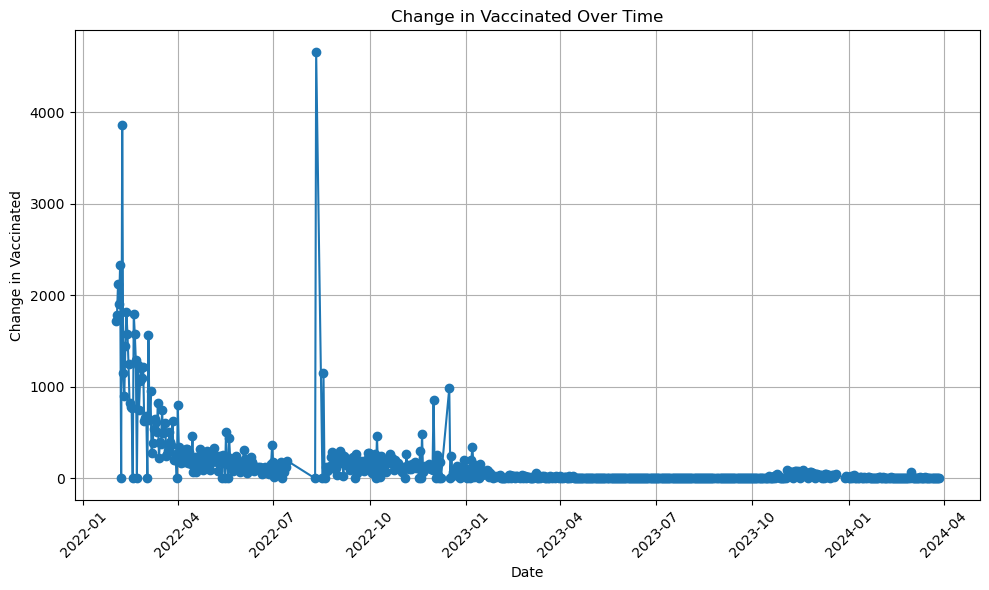

In [252]:
# # Plotting the data
plt.figure(figsize=(10, 6))

# Filter the DataFrame to include dates from 2022-01-01 onwards
data_vacs_days = data_vacs_days[data_vacs_days['date'] >= '2022-02-01']

plt.plot(data_vacs_days['date'], data_vacs_days['change_vaccinations'], marker='o', linestyle='-')
plt.title('Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Change in Vaccinated')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [253]:
# Count the number of negative values in the 'change_vaccinated' column
negative_count = (data_vacs_days['change_vaccinations'] < 0).sum()

print("Number of negative values in the 'change_vaccinated' column:", negative_count)

Number of negative values in the 'change_vaccinated' column: 0


# Holt's Method (Double Exponential Smoothing) - Days DataFrame 

In [254]:
# importing for Exponential Smoothing 

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [255]:
time_series_data = data_vacs_days.set_index('date')['total_vaccinated']

In [256]:
# Create Holt's exponential smoothing model 

model = ExponentialSmoothing(time_series_data, trend='add', damped=True)

In [257]:
# Fit Holt's exponential smoothing model 

fit_model = model.fit()

In [258]:
# Forecasting values for the next year (365 days)

forecast_steps = 365
forecast = fit_model.forecast(steps=forecast_steps)
forecast = np.ceil(forecast)
forecast.head()

729    1190674.0
730    1190678.0
731    1190682.0
732    1190685.0
733    1190689.0
dtype: float64

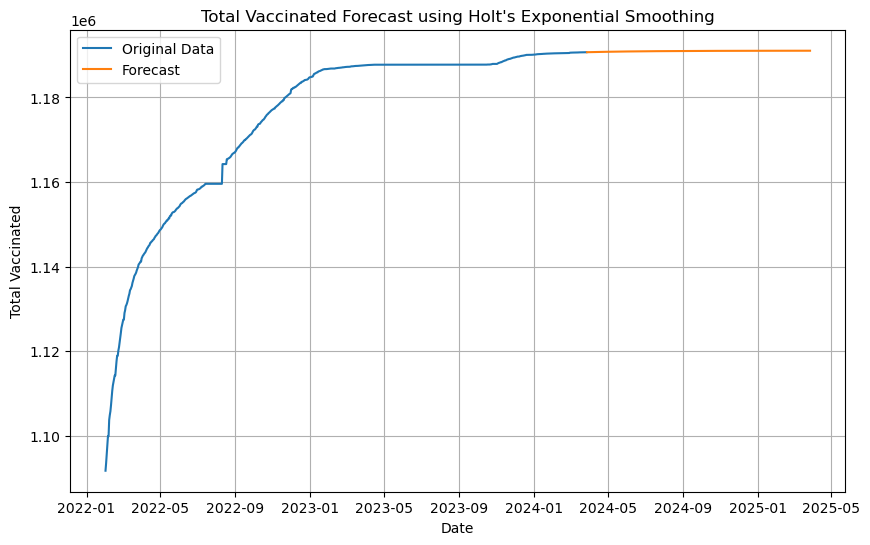

In [259]:
# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data')
plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps + 1, freq='D')[1:], forecast, label='Forecast')
plt.title('Total Vaccinated Forecast using Holt\'s Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.legend()
plt.grid(True)
plt.show()

In [260]:
# Create a dataframe from the forecast 

# Set the date as index
forecast_start_date = data_vacs_days['date'].iloc[-1] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='D')

# Create a dataframe from the forecast 
forecast_df = pd.DataFrame({'date': forecast_dates, 'Forecasted Total Vaccinated': forecast})

forecast_df.head()


,date,Forecasted Total Vaccinated
729,2024-03-28,1190674.0
730,2024-03-29,1190678.0
731,2024-03-30,1190682.0
732,2024-03-31,1190685.0
733,2024-04-01,1190689.0


In [261]:
# Get the last total vaccinated value from the original dataset
last_total_vaccinated = data_vacs_days['total_vaccinated'].iloc[-1]

# Add the Forecasted Change Vaccinated 
forecast_df['Forecasted Change Vaccinated'] = forecast_df['Forecasted Total Vaccinated'].diff()

# For the first row, use the last total vaccinated value
forecast_df['Forecasted Change Vaccinated'].iloc[0] = forecast_df['Forecasted Total Vaccinated'].iloc[0] - last_total_vaccinated

forecast_df.head()

,date,Forecasted Total Vaccinated,Forecasted Change Vaccinated
729,2024-03-28,1190674.0,4.0
730,2024-03-29,1190678.0,4.0
731,2024-03-30,1190682.0,4.0
732,2024-03-31,1190685.0,3.0
733,2024-04-01,1190689.0,4.0


In [262]:
forecast_df.tail()

,date,Forecasted Total Vaccinated,Forecasted Change Vaccinated
1089,2025-03-23,1191025.0,0.0
1090,2025-03-24,1191025.0,0.0
1091,2025-03-25,1191025.0,0.0
1092,2025-03-26,1191025.0,0.0
1093,2025-03-27,1191026.0,1.0


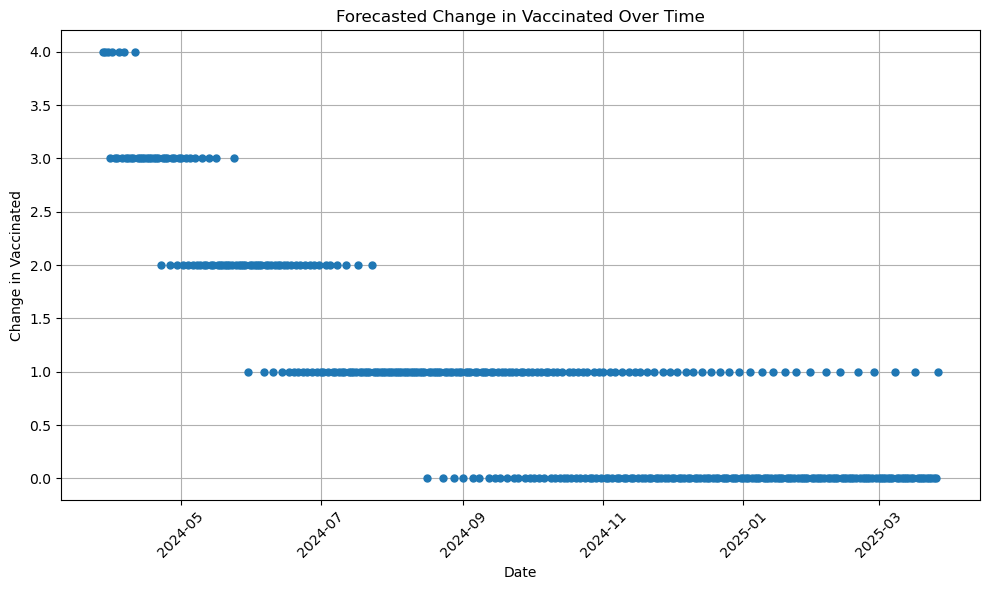

In [263]:
# Plotting the forecasted change vaccinated
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['date'], forecast_df['Forecasted Change Vaccinated'], marker='o', linestyle=' ', markersize=5)
plt.title('Forecasted Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Change in Vaccinated')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Error analysis for Holt's method (exponential smoothing) 

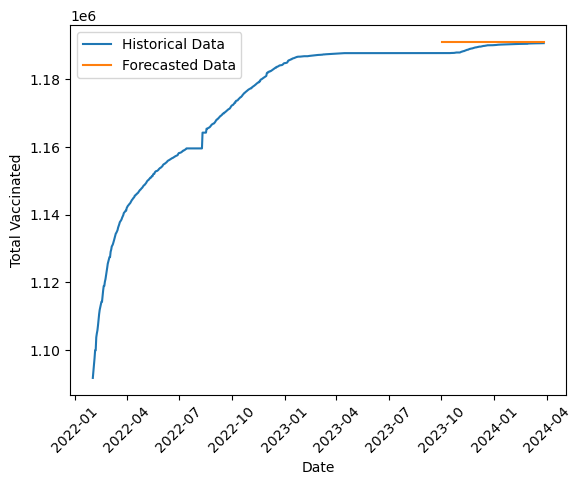

In [264]:
# Split data into training (until 2024-03-08) and testing (from 2023-03-09) sets
train_data = data_vacs_days[data_vacs_days['date'] <= '2023-10-01']
test_data = data_vacs_days[data_vacs_days['date'] >= '2023-10-02']

# Train the model
model = ExponentialSmoothing(time_series_data, trend='add', damped=True)
fit_model = model.fit()

# Forecast total vaccinated values for the entire desired time period
forecast_steps = len(test_data)
forecast = fit_model.predict(start=test_data.index.min(), end=test_data.index.max())

plt.plot(data_vacs_days['date'], data_vacs_days['total_vaccinated'], label='Historical Data')
plt.plot(test_data['date'], forecast, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [265]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['total_vaccinated'], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['total_vaccinated'], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse ** 0.5

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1433.8782409410042
Mean Squared Error (MSE): 3170162.0960055436
Root Mean Squared Error (RMSE): 1780.4949019880803


## Creating 10-week intervals

In [266]:
# Convert index to DatetimeIndex
forecast_df.index = pd.to_datetime(forecast_df.index)

# Assuming you want to group by 2-week intervals based on the date
# We find the min date and use it to calculate the difference in days for grouping
min_date = forecast_df['date'].min()
forecast_df['interval'] = (forecast_df['date'] - min_date).dt.days // 7

# Now, group by this 'interval' column and aggregate the data
grouped_data_vacs = forecast_df.groupby('interval').agg({
    'Forecasted Change Vaccinated': 'sum',
    'Forecasted Total Vaccinated': 'last',
    'date': ['min', 'max']
}).reset_index()

# Cleaning up the DataFrame columns
grouped_data_vacs.columns = ['Interval', 'Change Vaccinated', 'Total Vaccinated', 'Start Date', 'End Date']

print(grouped_data_vacs)

grouped_data_vacs.to_csv('Waterloo_Change_Vaccinated.csv', index=False)

    Interval  Change Vaccinated  Total Vaccinated Start Date   End Date
0          0               25.0         1190695.0 2024-03-28 2024-04-03
1          1               23.0         1190718.0 2024-04-04 2024-04-10
2          2               22.0         1190740.0 2024-04-11 2024-04-17
3          3               20.0         1190760.0 2024-04-18 2024-04-24
4          4               19.0         1190779.0 2024-04-25 2024-05-01
5          5               17.0         1190796.0 2024-05-02 2024-05-08
6          6               16.0         1190812.0 2024-05-09 2024-05-15
7          7               15.0         1190827.0 2024-05-16 2024-05-22
8          8               15.0         1190842.0 2024-05-23 2024-05-29
9          9               13.0         1190855.0 2024-05-30 2024-06-05
10        10               12.0         1190867.0 2024-06-06 2024-06-12
11        11               11.0         1190878.0 2024-06-13 2024-06-19
12        12               11.0         1190889.0 2024-06-20 202

## Plot to see Sum Change Vaccinated VS Interval

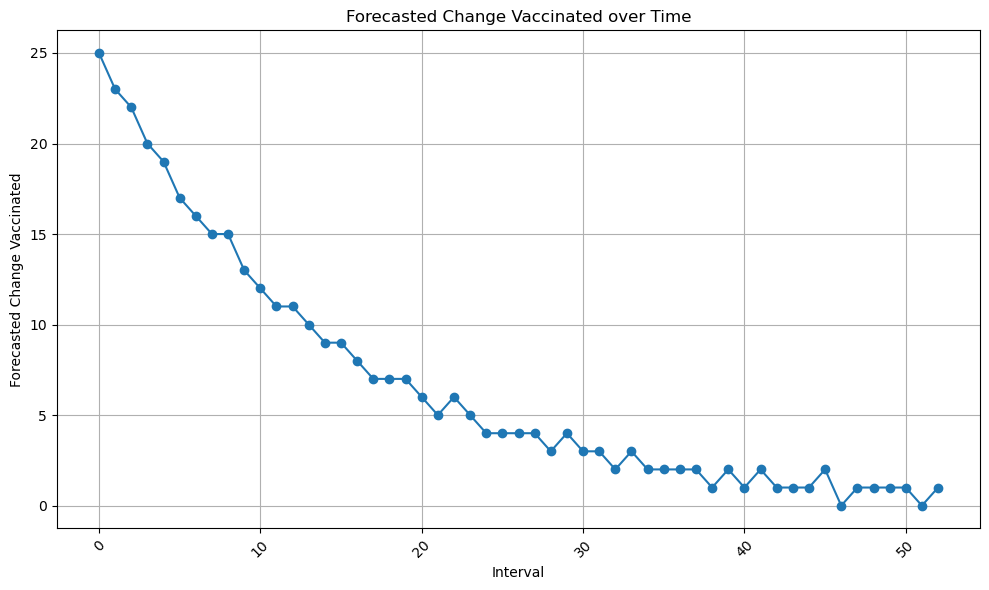

In [267]:
# This plot sees the change vaccinated over time in the 10 week intervals

plt.figure(figsize=(10, 6))
plt.plot(grouped_data_vacs.index, grouped_data_vacs['Change Vaccinated'], marker='o', linestyle='-')
plt.xlabel('Interval')
plt.ylabel('Forecasted Change Vaccinated')
plt.title('Forecasted Change Vaccinated over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

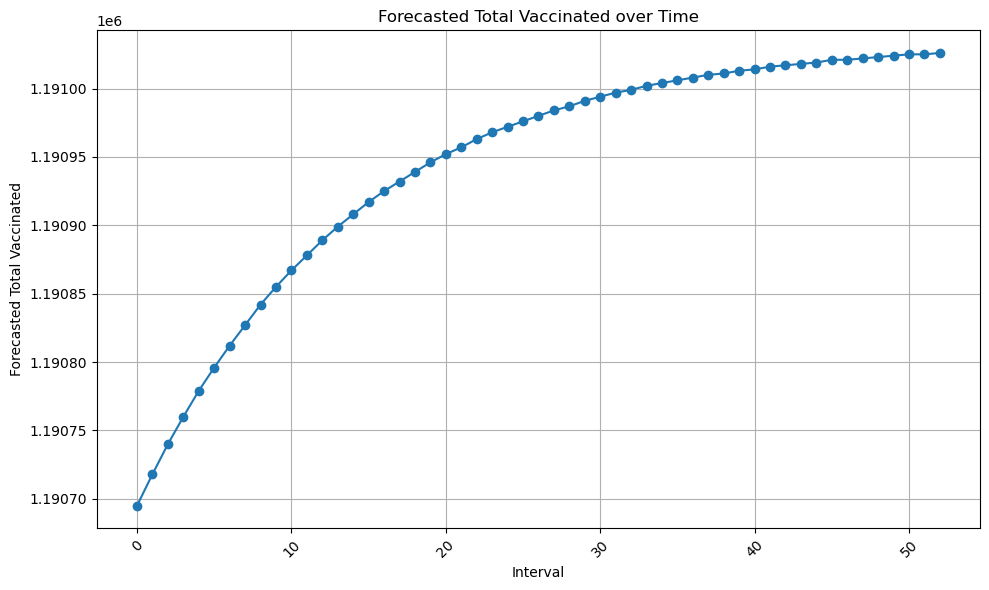

In [268]:
# This plot sees the total vaccinations over time in the 10 week intervals

plt.figure(figsize=(10, 6))
plt.plot(grouped_data_vacs.index, grouped_data_vacs['Total Vaccinated'], marker='o', linestyle='-')
plt.xlabel('Interval')
plt.ylabel('Forecasted Total Vaccinated')
plt.title('Forecasted Total Vaccinated over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Simple Exponential Smoothing

In [269]:
# imports for simple exponential smoothing 

from statsmodels.tsa.api import SimpleExpSmoothing

In [270]:
time_series_data = data_vacs_days.set_index('date')['total_vaccinated']

print(time_series_data)
model = SimpleExpSmoothing(time_series_data)
ses_model = model.fit(smoothing_level = 0.2)

date
2022-02-01    1091797.0
2022-02-02    1093580.0
2022-02-03    1095698.0
2022-02-04    1097605.0
2022-02-05    1099936.0
                ...    
2024-03-23    1190657.0
2024-03-24    1190659.0
2024-03-25    1190660.0
2024-03-26    1190668.0
2024-03-27    1190670.0
Name: total_vaccinated, Length: 729, dtype: float64


In [271]:
forecast_steps = 365
forecast = ses_model.forecast(steps=forecast_steps)
forecast = np.ceil(forecast)
forecast.head()

729    1190656.0
730    1190656.0
731    1190656.0
732    1190656.0
733    1190656.0
dtype: float64

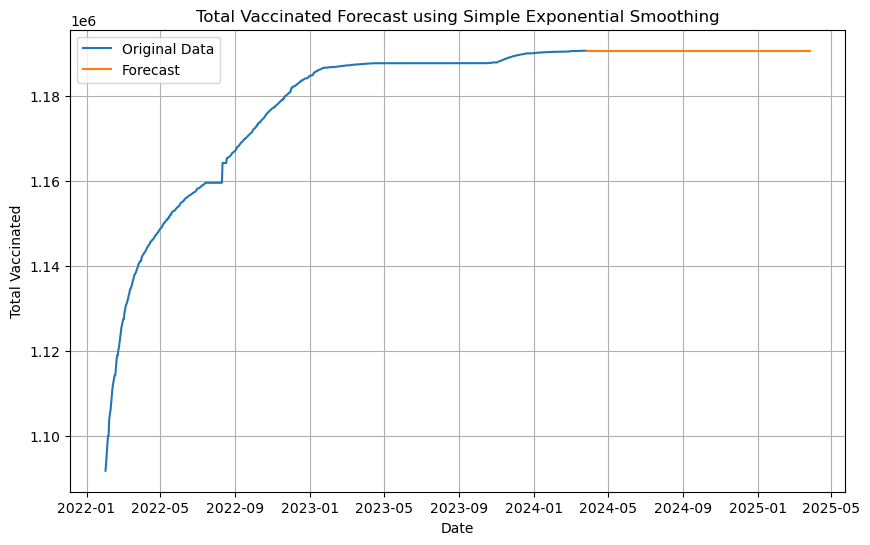

In [272]:
plt.figure(figsize=(10, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data')
plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps + 1, freq='D')[1:], forecast, label='Forecast')
plt.title('Total Vaccinated Forecast using Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.legend()
plt.grid(True)
plt.show()

In [273]:
# Create a dataframe from the forecast 

# Set the date as index
forecast_start_date = data_vacs_days['date'].iloc[-1] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='D')

# Create a dataframe from the forecast 
forecast_df = pd.DataFrame({'date': forecast_dates, 'Forecasted Total Vaccinated': forecast})

forecast_df.head()

# Add the Forecasted Change Vaccinated 

forecast_df['Forecasted Change Vaccinated'] = forecast_df['Forecasted Total Vaccinated'].diff()

# Get the last total vaccinated value from the original dataset
last_total_vaccinated = data_vacs_days['total_vaccinated'].iloc[-1]

# For the first row, use the last total vaccinated value
forecast_df['Forecasted Change Vaccinated'].iloc[0] = 0


forecast_df.head()

,date,Forecasted Total Vaccinated,Forecasted Change Vaccinated
729,2024-03-28,1190656.0,0.0
730,2024-03-29,1190656.0,0.0
731,2024-03-30,1190656.0,0.0
732,2024-03-31,1190656.0,0.0
733,2024-04-01,1190656.0,0.0


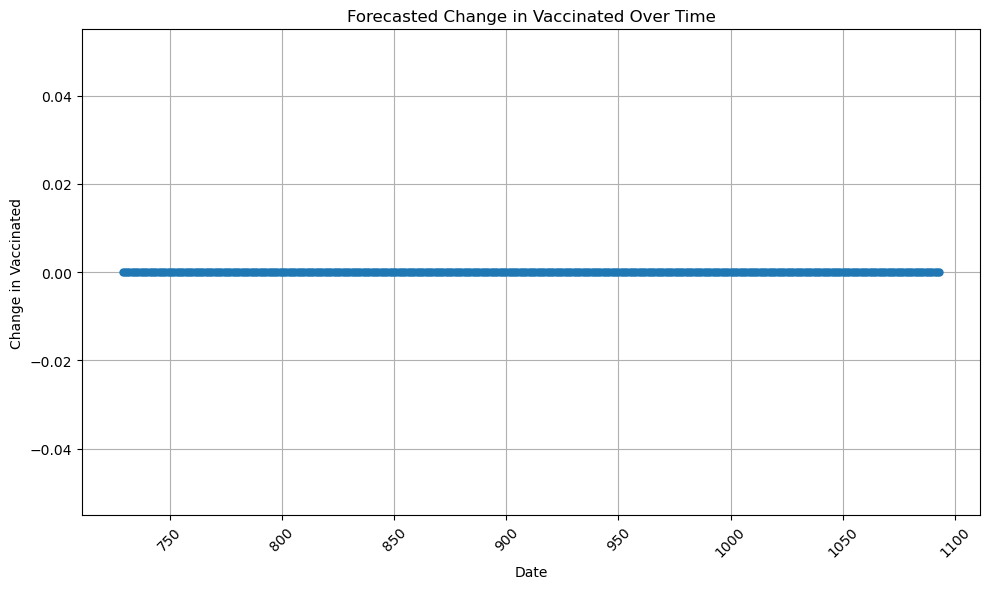

In [274]:
# Plotting the forecasted change vaccinated
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df['Forecasted Change Vaccinated'], marker='o', linestyle='', markersize=5)
plt.title('Forecasted Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Change in Vaccinated')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Error analysis for Holt's method (exponential smoothing) 

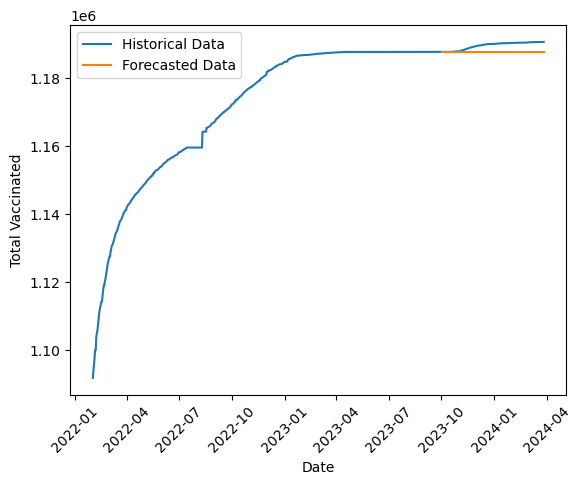

In [275]:
# Convert 'date' column to datetime
data_vacs_days['date'] = pd.to_datetime(data_vacs_days['date'])

# Split data into training (until 2024-03-08) and testing (from 2024-03-09) sets
train_data = data_vacs_days[data_vacs_days['date'] <= '2023-10-01']
test_data = data_vacs_days[data_vacs_days['date'] >= '2023-10-02']

# Extract time series data for training
time_series_data = train_data.set_index('date')['total_vaccinated']

# Train the model
model = SimpleExpSmoothing(time_series_data)
ses_model = model.fit()

# Forecast total vaccinated values for the entire desired time period
forecast_steps = len(test_data)
forecast = ses_model.predict(start=test_data.index.min(), end=test_data.index.max())

plt.plot(data_vacs_days['date'], data_vacs_days['total_vaccinated'], label='Historical Data')
plt.plot(test_data['date'], forecast, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [276]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['total_vaccinated'], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['total_vaccinated'], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse ** 0.5

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1878.9408284023668
Mean Squared Error (MSE): 4645085.650887574
Root Mean Squared Error (RMSE): 2155.246076643587


# Linear Regression Model

In [277]:
# Convert dates to timestamps
X = data_vacs_days['date'].astype('int64').values.reshape(-1, 1)
y = data_vacs_days['change_vaccinations'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

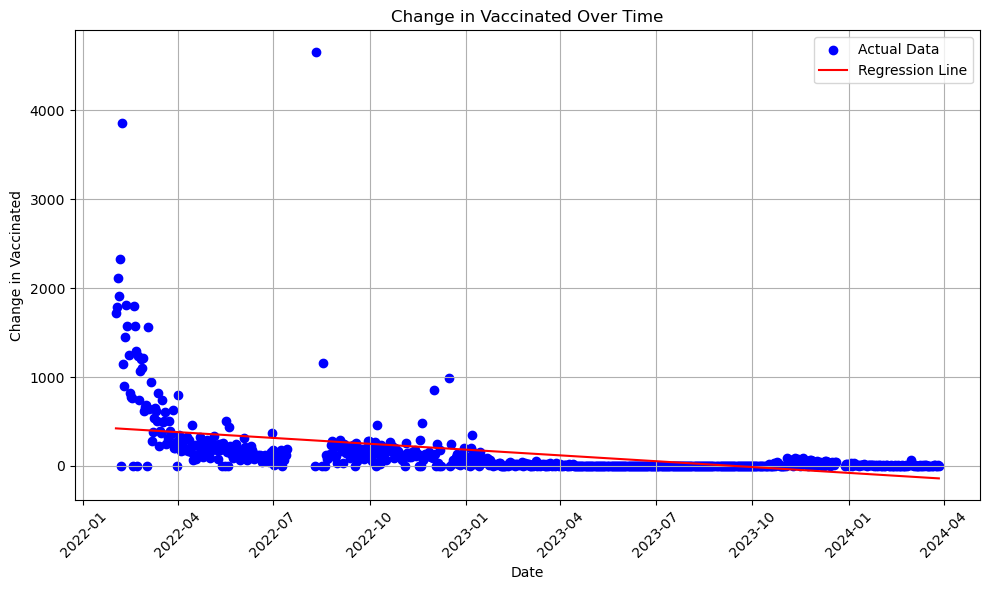

In [278]:
# Plot the original data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(data_vacs_days['date'], data_vacs_days['change_vaccinations'], color='blue', label='Actual Data')
plt.plot(data_vacs_days['date'], model.predict(X), color='red', label='Regression Line')
plt.title('Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Change in Vaccinated')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [279]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse ** 0.5

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 178.29771183635512
Mean Squared Error (MSE): 196922.02058566653
Root Mean Squared Error (RMSE): 443.7589667664942


In [280]:
# Convert dates to timestamps

# Make predictions for the next 2 years (1008 days)
future_dates = pd.date_range(start=data_vacs_days['date'].iloc[-1], periods=365)
future_dates_timestamps = future_dates.astype('int64').values.reshape(-1, 1)
forecast_total_vaccinated = model.predict(future_dates_timestamps)

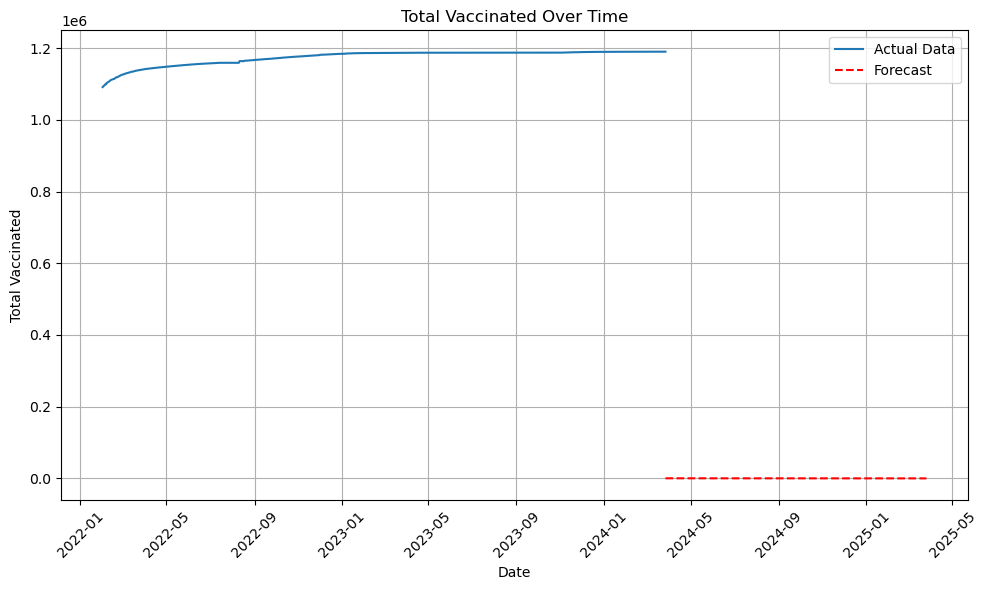

In [281]:
# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data_vacs_days['date'], data_vacs_days['total_vaccinated'], label='Actual Data')
plt.plot(future_dates, forecast_total_vaccinated, label='Forecast', linestyle='--', color='red')
plt.title('Total Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [282]:
# Create a DataFrame for the forecasted total vaccinated values
forecasted_total_df = pd.DataFrame({'date': future_dates, 'forecasted_total_vaccinated': forecast_total_vaccinated})

print(forecasted_total_df)

          date  forecasted_total_vaccinated
0   2024-03-27                  -140.150448
1   2024-03-28                  -140.867208
2   2024-03-29                  -141.583969
3   2024-03-30                  -142.300730
4   2024-03-31                  -143.017490
..         ...                          ...
360 2025-03-22                  -398.184275
361 2025-03-23                  -398.901036
362 2025-03-24                  -399.617796
363 2025-03-25                  -400.334557
364 2025-03-26                  -401.051318

[365 rows x 2 columns]


## Forecasted Change

In [283]:
forecasted_change_vaccinated = np.diff(np.concatenate([[data_vacs_days['total_vaccinated'].iloc[-1]], forecast_total_vaccinated]))

future_dates = future_dates[:-1]
forecasted_change_vaccinated = forecasted_change_vaccinated[:-1]

# Create a DataFrame for the forecasted change in vaccinated
forecasted_change_df = pd.DataFrame({'date': future_dates, 'forecasted_change_vaccinated': forecasted_change_vaccinated})

# Get the last total vaccinated value from the original dataset
last_total_vaccinated = data_vacs_days['total_vaccinated'].iloc[-1]

# For the first row, use the last total vaccinated value
first_forecasted_total_vaccinated = forecast_total_vaccinated[0]
forecasted_change_df['forecasted_change_vaccinated'].iloc[0] = first_forecasted_total_vaccinated - last_total_vaccinated

print(forecasted_change_df.head())


        date  forecasted_change_vaccinated
0 2024-03-27                 -1.190810e+06
1 2024-03-28                 -7.167606e-01
2 2024-03-29                 -7.167606e-01
3 2024-03-30                 -7.167606e-01
4 2024-03-31                 -7.167606e-01


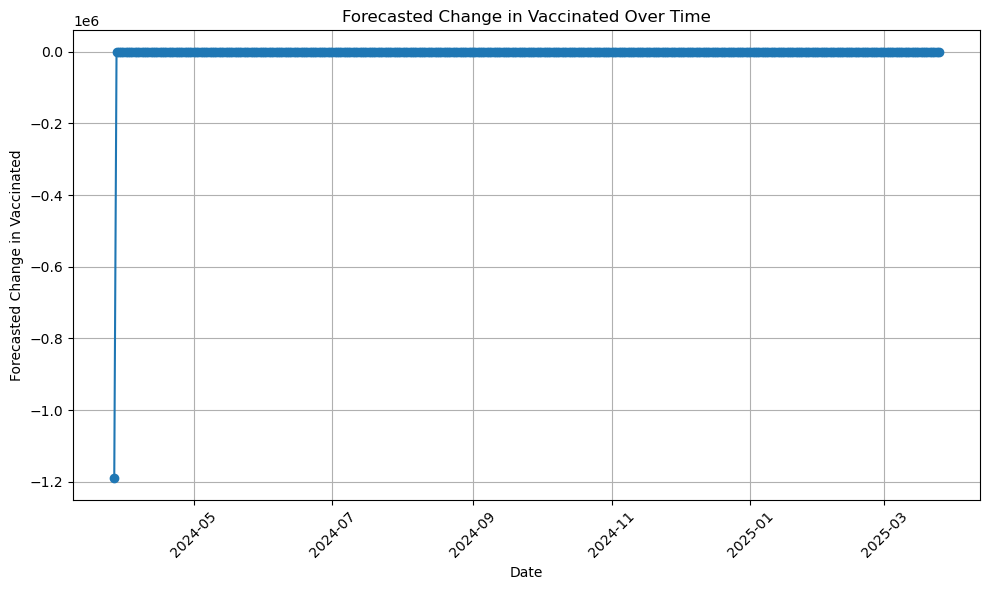

In [284]:
# Plot the forecasted change in vaccinated
plt.figure(figsize=(10, 6))
plt.plot(forecasted_change_df['date'], forecasted_change_df['forecasted_change_vaccinated'], marker='o', linestyle='-')
plt.title('Forecasted Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Forecasted Change in Vaccinated')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()